<a href="https://colab.research.google.com/github/sasandi123/telco-churn-ml-project/blob/main/Telco_Churn_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial Setup & Configuration

In [1]:
# Install Keras Tuner for hyperparameter search (required for NN tuning)
!pip install keras-tuner

from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import seaborn as sns
import matplotlib.pyplot as plt

# Define the project path where your data is located
PROJECT_PATH = "/content/drive/MyDrive/telco_churn_ml_project/data"

if not os.path.exists(PROJECT_PATH):
    os.makedirs(PROJECT_PATH)

os.chdir(PROJECT_PATH)
print(f"Working directory set to: {os.getcwd()}")


# SUBTOPIC: Imports and Global Settings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from tensorflow.keras import layers, callbacks

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("\nAll libraries loaded and seeds set for reproducibility.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 2.3 MB/s eta 0:00:00
Mounted at /content/drive
Working directory set to: /content/drive/MyDrive/telco_churn_ml_project/data

All libraries loaded and seeds set for reproducibility.


Data Loading

In [2]:
FILE_NAME = "WA_Fn-UseC_-Telco-Customer-Churn.csv"

try:
    # SUBTOPIC: Load Data
    df = pd.read_csv(FILE_NAME)
    print(f"Loaded dataset: {df.shape}")

except Exception as e:
    print(f"An error occurred during loading: {e}")
    df = pd.DataFrame()

Loaded dataset: (7043, 21)


Data Cleaning

In [3]:
if not df.empty:
    # Convert 'TotalCharges' to numeric, coercing errors to NaN
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
    # Impute missing values (where tenure=0) with the median
    df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())
    df.drop_duplicates(inplace=True)
    print(f"After cleaning and imputation: {df.shape}")

After cleaning and imputation: (7043, 21)


Task 1

Target Variable Analysis


Churn Distribution:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


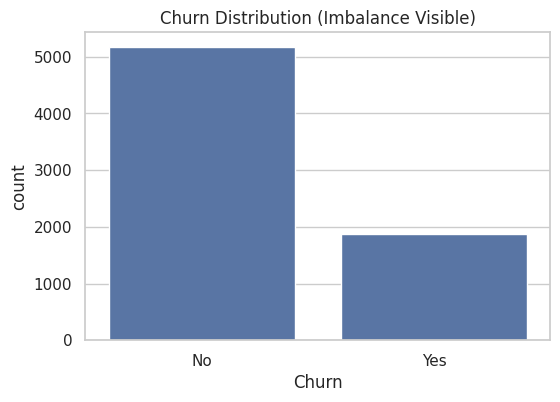

In [4]:
if not df.empty:
    # SUBTOPIC: Churn Distribution and Imbalance Check
    print("\nChurn Distribution:")
    print(df["Churn"].value_counts(normalize=True) * 100)
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x="Churn")
    plt.title("Churn Distribution (Imbalance Visible)")
    plt.show()

Exploratory Data Analysis (EDA) Visualizations

Numerical Feature Analysis (Outlier Visualization)


Numerical Feature Analysis (Distribution and Outliers):


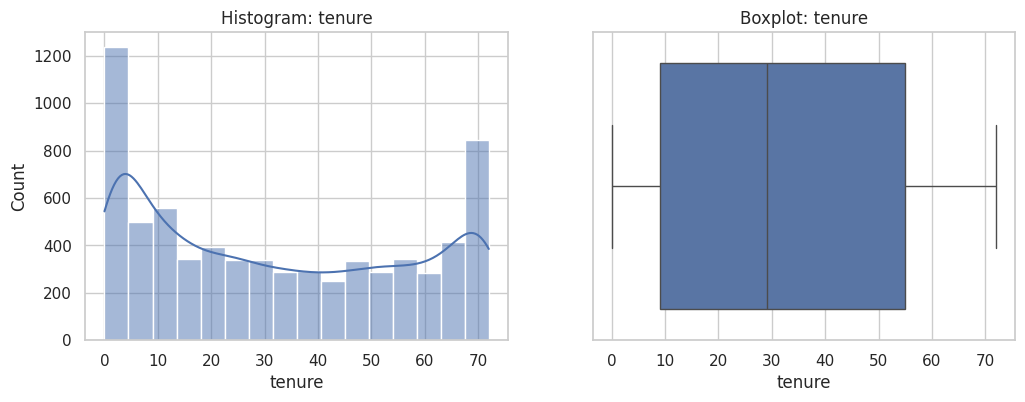

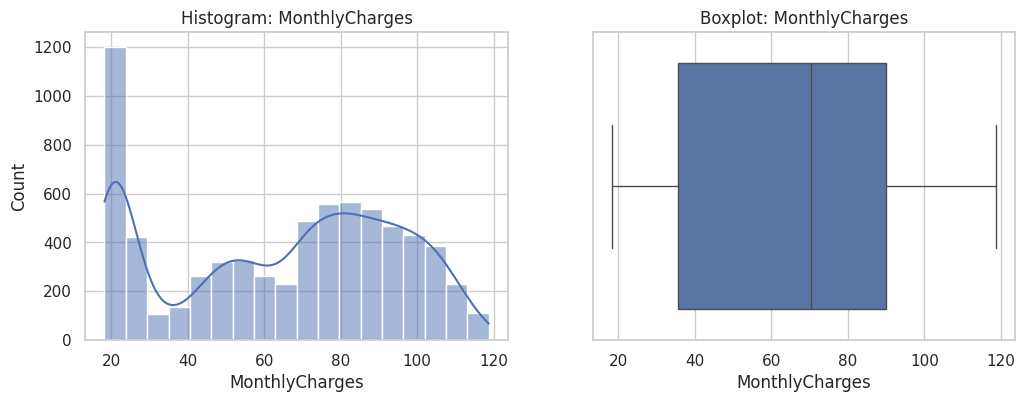

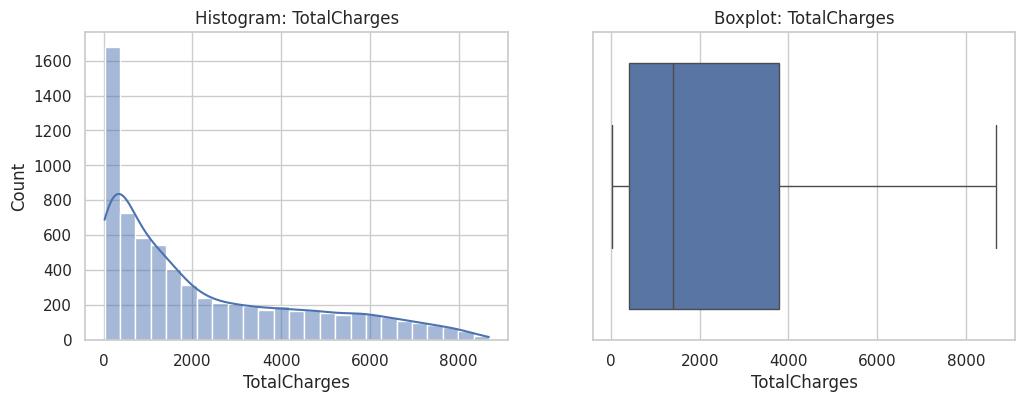

In [7]:
if not df.empty:
  # SUBTOPIC: Numerical Feature Analysis (Distribution and Potential Outliers)
  num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
  print("\nNumerical Feature Analysis (Distribution and Outliers):")

  # Plot histograms and boxplots for each numerical column
  for col in num_cols:
      plt.figure(figsize=(12, 4))

      plt.subplot(1, 2, 1)
      sns.histplot(df[col], kde=True)
      plt.title(f"Histogram: {col}")

      plt.subplot(1, 2, 2)
      sns.boxplot(x=df[col])
      plt.title(f"Boxplot: {col}")
      plt.show() #

Correlation HeatMap

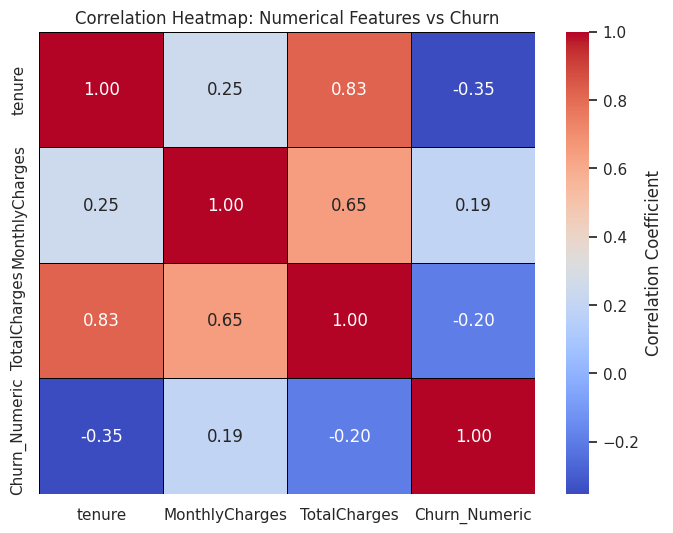

In [8]:
if not df.empty:
    # SUBTOPIC: Correlation Matrix of Numerical Features and Churn
    df_corr = df.copy()
    # Convert Churn to numeric (0/1) for correlation calculation
    df_corr["Churn_Numeric"] = df_corr["Churn"].map({"No": 0, "Yes": 1})

    num_cols_with_target = ["tenure", "MonthlyCharges", "TotalCharges", "Churn_Numeric"]

    plt.figure(figsize=(8, 6))
    correlation_matrix = df_corr[num_cols_with_target].corr()

    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        linewidths=0.5,
        linecolor="black",
        cbar_kws={'label': 'Correlation Coefficient'}
    )
    plt.title("Correlation Heatmap: Numerical Features vs Churn")
    plt.show() #

Categorical Feature Analysis (EDA)

Categorical Feature Analysis (Distribution and Churn Breakdown):


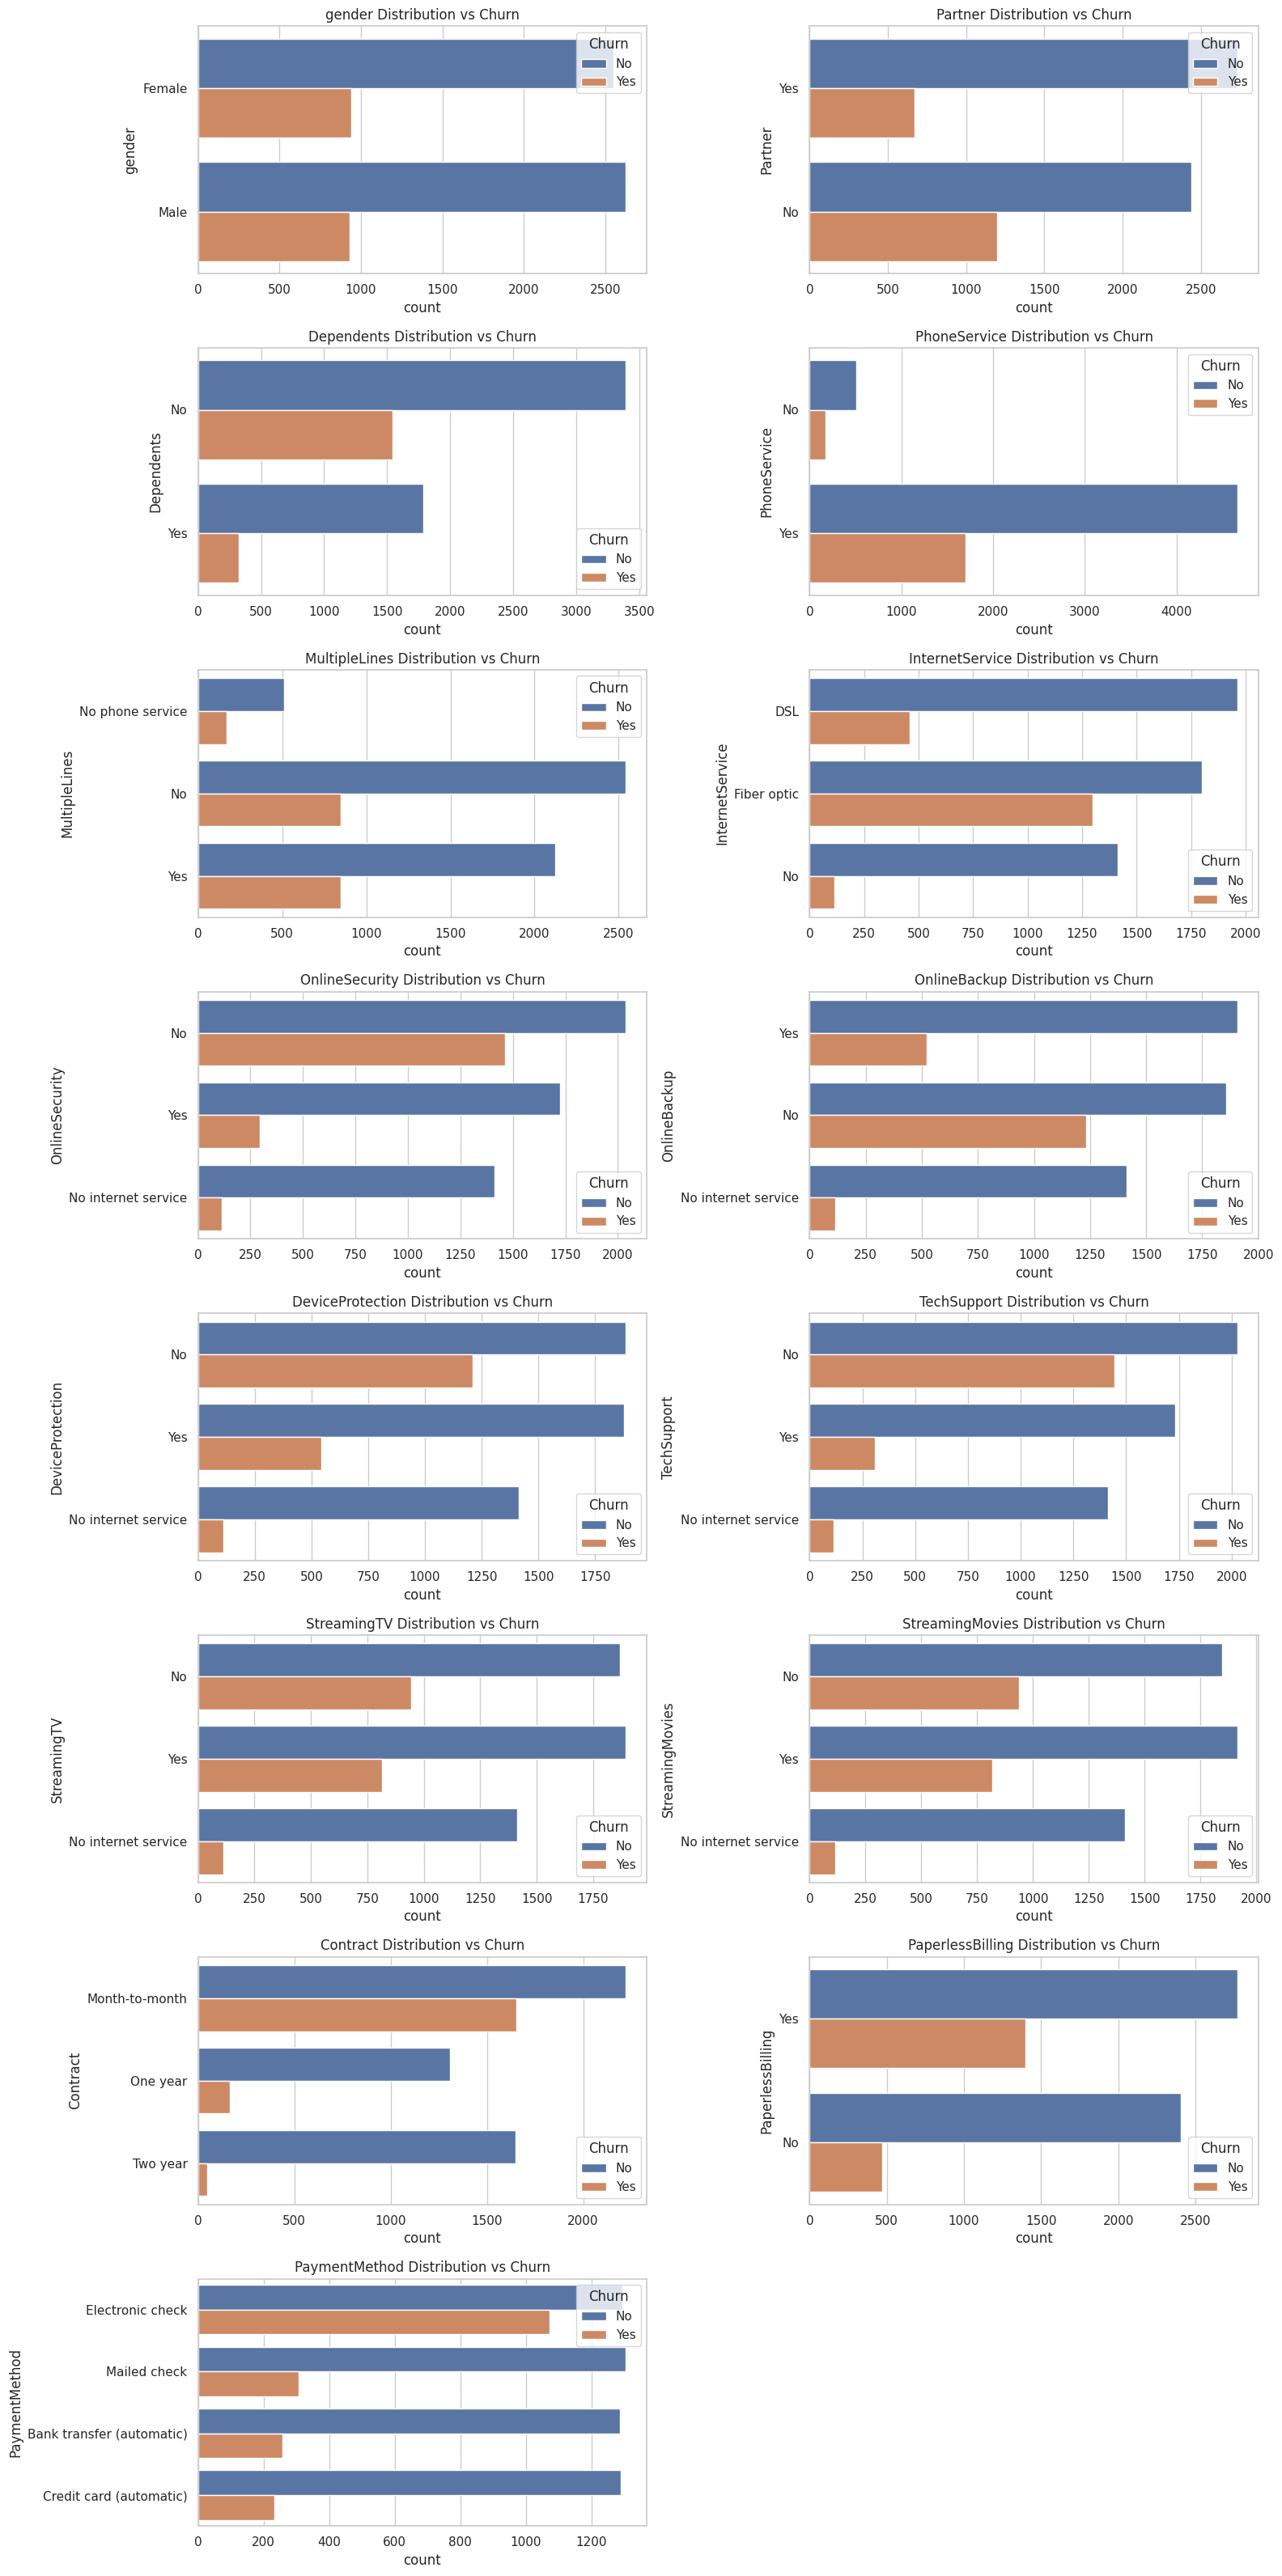

In [9]:
if not df.empty:
    # Categorical Feature Analysis (Distribution vs Churn)
    cat_cols = df.select_dtypes(include="object").columns.tolist()
    # Exclude target and ID
    cat_cols_to_plot = [col for col in cat_cols if col not in ["customerID", "Churn"]]

    n_plots = len(cat_cols_to_plot)
    n_rows = (n_plots // 2) + (n_plots % 2)

    plt.figure(figsize=(16, 4 * n_rows))
    print("Categorical Feature Analysis (Distribution and Churn Breakdown):")

    for i, col in enumerate(cat_cols_to_plot):
        plt.subplot(n_rows, 2, i + 1)
        # Use hue='Churn' for deeper insight into relationship with the target
        sns.countplot(y=col, data=df, hue='Churn')
        plt.title(f"{col} Distribution vs Churn")

    plt.tight_layout()
    plt.show()

Feature Engineering

Three new engineered features created: service_count, has_auto_payment, is_high_risk.


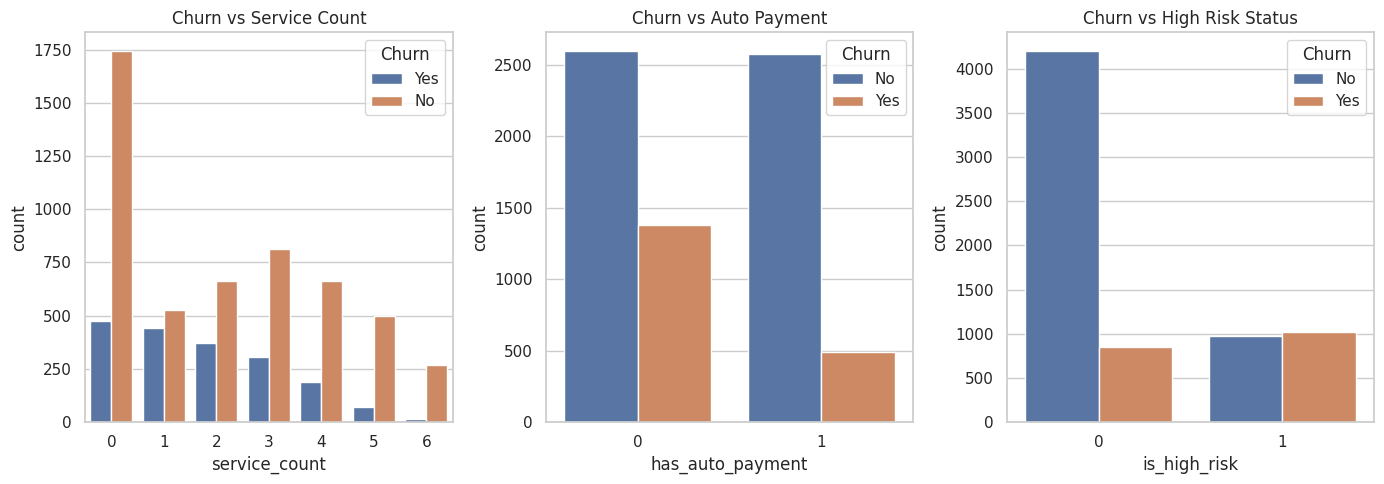

In [10]:
if not df.empty:
    df_fe = df.copy()

    # SUBTOPIC: Creation of New Features
    # 1. Service Count: Count of premium services subscribed
    service_features = [
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
        'TechSupport', 'StreamingTV', 'StreamingMovies'
    ]
    df_fe["service_count"] = (df_fe[service_features] == "Yes").sum(axis=1)

    # 2. Auto Payment Flag: Binary flag for automatic payment methods
    auto_payments = ["Bank transfer (automatic)", "Credit card (automatic)"]
    df_fe["has_auto_payment"] = df_fe["PaymentMethod"].isin(auto_payments).astype(int)

    # 3. High-Risk Customer Flag: Month-to-month contract AND short tenure (<= 12 months)
    df_fe["is_high_risk"] = ((df_fe["tenure"] <= 12) &
                             (df_fe["Contract"] == "Month-to-month")).astype(int)

    print("Three new engineered features created: service_count, has_auto_payment, is_high_risk.")

    # SUBTOPIC: Visualization of New Features vs Churn
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 3, 1)
    sns.countplot(x="service_count", hue="Churn", data=df_fe)
    plt.title("Churn vs Service Count")

    plt.subplot(1, 3, 2)
    sns.countplot(x="has_auto_payment", hue="Churn", data=df_fe)
    plt.title("Churn vs Auto Payment")

    plt.subplot(1, 3, 3)
    sns.countplot(x="is_high_risk", hue="Churn", data=df_fe)
    plt.title("Churn vs High Risk Status")
    plt.tight_layout()
    plt.show()

Data Preprocessing & Dual Transformation

In [11]:
if not df.empty:
    df_model = df_fe.drop("customerID", axis=1)
    df_model["Churn"] = df_model["Churn"].map({"No": 0, "Yes": 1})

    X = df_model.drop("Churn", axis=1)
    y = df_model["Churn"]

    # SUBTOPIC: Train–Test Split (80/20, stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    categorical_cols = X_train.select_dtypes(include="object").columns.tolist()
    numerical_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

    # --- Preprocessor 1 (FOR NN): Scaling + One-Hot Encoding ---
    # Scaling is REQUIRED for Neural Networks
    nn_preprocessor = ColumnTransformer([
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)
    ])

    # --- Preprocessor 2 (FOR DT): Passthrough + One-Hot Encoding ---
    # Scaling is NOT REQUIRED for Decision Trees
    dt_preprocessor = ColumnTransformer([
        ("num_passthrough", "passthrough", numerical_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)
    ])

    # SUBTOPIC: Data Transformation for NN (Scaled Numerical Features)
    X_train_nn_scaled = nn_preprocessor.fit_transform(X_train)
    X_test_nn_scaled = nn_preprocessor.transform(X_test)

    # SUBTOPIC: Data Transformation for DT (Unscaled Numerical Features)
    X_train_dt_unscaled = dt_preprocessor.fit_transform(X_train)
    X_test_dt_unscaled = dt_preprocessor.transform(X_test)

    # SUBTOPIC: Class Weight Calculation (Crucial for imbalanced data - Task 3)
    weights = compute_class_weight(
        class_weight="balanced", classes=np.unique(y_train), y=y_train
    )
    class_weights_dict = {0: weights[0], 1: weights[1]}
    print("Class weights (used for all models):", class_weights_dict)

    # SUBTOPIC: Train–Validation Split for Neural Network Tuning
    X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
        X_train_nn_scaled, y_train, test_size=0.2, stratify=y_train, random_state=42
    )
    input_dim = X_train_nn.shape[1]
    print(f"Total input features (dimensions): {input_dim}")

Class weights (used for all models): {0: np.float64(0.6805991785455424), 1: np.float64(1.8842809364548494)}
Total input features (dimensions): 33


Decision Tree Models

In [12]:
# ================================================================
# MAIN TOPIC: TASK 2 - DECISION TREE MODELS (USING UNSCALED DATA)
# ================================================================

if not df.empty:
    # SUBTOPIC: Decision Tree - Baseline Model
    # Uses X_train_dt_unscaled / X_test_dt_unscaled
    dt_base = DecisionTreeClassifier(random_state=42, class_weight=class_weights_dict)
    dt_base.fit(X_train_dt_unscaled, y_train)
    y_proba_dt_base = dt_base.predict_proba(X_test_dt_unscaled)[:, 1]
    dt_base_acc = accuracy_score(y_test, dt_base.predict(X_test_dt_unscaled))
    dt_base_auc = roc_auc_score(y_test, y_proba_dt_base)
    print("===== BASELINE DECISION TREE =====")
    print(f"Accuracy: {dt_base_acc:.4f} | ROC-AUC: {dt_base_auc:.4f}")

    # SUBTOPIC: Decision Tree - Tuned Model (Pruning via GridSearchCV)
    # Uses X_train_dt_unscaled / X_test_dt_unscaled
    param_grid = {"max_depth": [4, 6, 8, 10, None], "min_samples_split": [2, 5, 10]}
    dt_tuner = GridSearchCV(
        DecisionTreeClassifier(random_state=42, class_weight=class_weights_dict),
        param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=0
    )
    dt_tuner.fit(X_train_dt_unscaled, y_train)
    best_dt = dt_tuner.best_estimator_

    y_proba_dt_tuned = best_dt.predict_proba(X_test_dt_unscaled)[:, 1]
    dt_tuned_acc = accuracy_score(y_test, best_dt.predict(X_test_dt_unscaled))
    dt_tuned_auc = roc_auc_score(y_test, y_proba_dt_tuned)

    print("\n===== TUNED DECISION TREE (OPTIMALLY PRUNED) =====")
    print("Best params:", dt_tuner.best_params_)
    print(f"Accuracy: {dt_tuned_acc:.4f} | ROC-AUC: {dt_tuned_auc:.4f}")

===== BASELINE DECISION TREE =====
Accuracy: 0.7346 | ROC-AUC: 0.6539

===== TUNED DECISION TREE (OPTIMALLY PRUNED) =====
Best params: {'max_depth': 4, 'min_samples_split': 2}
Accuracy: 0.7438 | ROC-AUC: 0.8176


Neural Network Baseline Model

In [13]:
# ================================================================
# MAIN TOPIC: TASK 2 - NEURAL NETWORK (NN) BASELINE MODEL (USING SCALED DATA)
# ================================================================

if not df.empty:
    # SUBTOPIC: NN Baseline Model Definition and Training
    def build_baseline_nn(input_dim):
        model = keras.Sequential([
            layers.Dense(32, activation="relu", input_shape=(input_dim,)),
            layers.Dense(1, activation="sigmoid")
        ])
        model.compile(
            optimizer="adam", loss="binary_crossentropy", metrics=[keras.metrics.AUC(name="AUC"), "accuracy"]
        )
        return model

    baseline_nn = build_baseline_nn(input_dim)
    es = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)

    # NOTE: Training and prediction use scaled data
    history_base = baseline_nn.fit(
        X_train_nn, y_train_nn, validation_data=(X_val_nn, y_val_nn),
        epochs=30, batch_size=32, class_weight=class_weights_dict, callbacks=[es], verbose=0
    )

    y_proba_base_nn = baseline_nn.predict(X_test_nn_scaled).ravel()
    y_pred_base_nn = (y_proba_base_nn >= 0.5).astype(int)
    nn_base_acc = accuracy_score(y_test, y_pred_base_nn)
    nn_base_auc = roc_auc_score(y_test, y_proba_base_nn)

    print("===== BASELINE NEURAL NETWORK =====")
    print(f"Accuracy (0.5 Thresh): {nn_base_acc:.4f} | AUC: {nn_base_auc:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
===== BASELINE NEURAL NETWORK =====
Accuracy (0.5 Thresh): 0.7388 | AUC: 0.8422


NN Tuning Model Setup and Search

In [14]:
# ================================================================
# MAIN TOPIC: TASK 2 - NEURAL NETWORK TUNING SETUP & SEARCH
# ================================================================

if not df.empty:
    # SUBTOPIC: NN Tunable Model Definition (with L2 Reg for robustness)
    def build_tunable_model(hp):
        model = keras.Sequential()
        model.add(layers.Input(shape=(input_dim,)))

        n_layers = hp.Int("n_layers", 1, 2)
        lr = hp.Choice("lr", [1e-4, 5e-4, 1e-3])

        for i in range(n_layers):
            units = hp.Int(f"units_{i}", 32, 128, step=32)
            l2_reg = hp.Choice("l2_reg", [1e-4, 1e-3, 0.0]) # L2 Regularization included for robustness

            model.add(layers.Dense(
                units, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg)
            ))
            model.add(layers.Dropout(hp.Float(f"dropout_{i}", 0.1, 0.3, step=0.1)))

        model.add(layers.Dense(1, activation="sigmoid"))

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
            loss="binary_crossentropy", metrics=[keras.metrics.AUC(name="AUC"), "accuracy"]
        )
        return model

    # SUBTOPIC: Keras Tuner Search (Optimizing for AUC)
    tuner = kt.RandomSearch(
        build_tunable_model, objective=kt.Objective("val_AUC", "max"),
        max_trials=10, directory="nn_tuner_final_v3", project_name="telco_nn_l2_final",
        overwrite=True
    )
    print("Starting Keras Tuner search (Optimizing for AUC)... This may take a few minutes.")
    tuner.search(
        X_train_nn, y_train_nn, validation_data=(X_val_nn, y_val_nn),
        epochs=30, batch_size=32, class_weight=class_weights_dict, callbacks=[es], verbose=0
    )

    best_hps = tuner.get_best_hyperparameters(1)[0]
    print("\nBest NN Hyperparameters found:", best_hps.values)

Starting Keras Tuner search (Optimizing for AUC)... This may take a few minutes.

Best NN Hyperparameters found: {'n_layers': 1, 'lr': 0.001, 'units_0': 32, 'l2_reg': 0.0, 'dropout_0': 0.1, 'units_1': 32, 'dropout_1': 0.1}


Tuned NN Final Training and Optimal Threshold

In [15]:
# ================================================================
# MAIN TOPIC: TASK 2 - TUNED NN FINAL TRAINING & OPTIMAL THRESHOLD
# ================================================================

if not df.empty:
    # SUBTOPIC: Training the Best NN Model
    best_model = tuner.hypermodel.build(best_hps)
    history_tuned = best_model.fit(
        X_train_nn, y_train_nn, validation_data=(X_val_nn, y_val_nn),
        epochs=40, batch_size=32, class_weight=class_weights_dict, callbacks=[es], verbose=0
    )

    # Predicting on X_test_nn_scaled
    y_proba_tuned_nn = best_model.predict(X_test_nn_scaled).ravel()
    nn_tuned_auc = roc_auc_score(y_test, y_proba_tuned_nn)

    # SUBTOPIC: Optimal Threshold Calculation (G-Mean)
    # This finds the best probability cutoff for classification balance
    fpr, tpr, thresholds = roc_curve(y_test, y_proba_tuned_nn)
    gmeans = np.sqrt(tpr * (1 - fpr))
    best_thresh = thresholds[np.argmax(gmeans)]

    y_pred_tuned_opt_thresh = (y_proba_tuned_nn >= best_thresh).astype(int)
    nn_tuned_opt_acc = accuracy_score(y_test, y_pred_tuned_opt_thresh)

    print("\n===== TUNED NN FINAL METRICS (BEST CLASSIFICATION) =====")
    print(f"Optimal probability threshold (G-Mean): {best_thresh:.4f}")
    print(f"Best Achieved Accuracy: {nn_tuned_opt_acc:.4f} | AUC: {nn_tuned_auc:.4f}")
    print(classification_report(y_test, y_pred_tuned_opt_thresh))

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

===== TUNED NN FINAL METRICS (BEST CLASSIFICATION) =====
Optimal probability threshold (G-Mean): 0.5139
Best Achieved Accuracy: 0.7459 | AUC: 0.8445
              precision    recall  f1-score   support

           0       0.91      0.72      0.81      1035
           1       0.51      0.81      0.63       374

    accuracy                           0.75      1409
   macro avg       0.71      0.77      0.72      1409
weighted avg       0.81      0.75      0.76      1409



inal Evaluation Table & Task 3 Summary

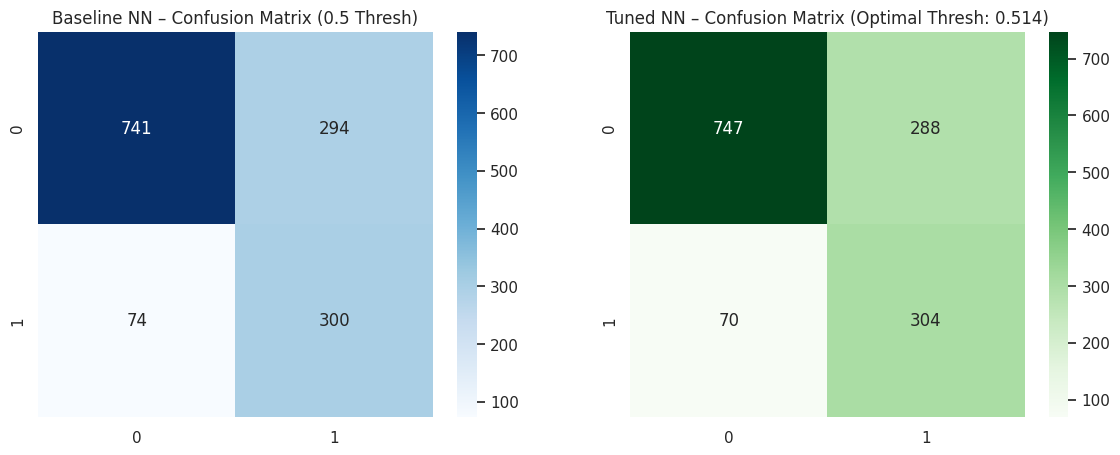

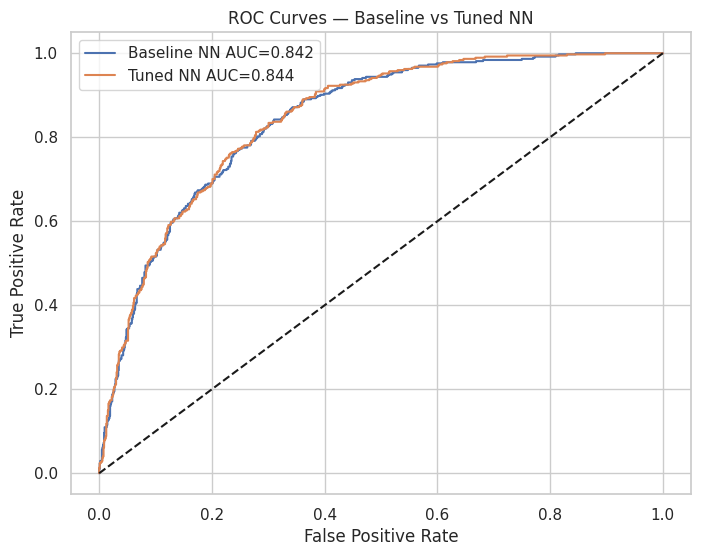


===== FINAL MODEL COMPARISON =====
Note: Tuned NN Accuracy is evaluated at its optimal threshold (G-Mean) for the best classification result.
| Model                           |   Accuracy (Best Classification) |   AUC (Ranking Quality) |
|:--------------------------------|---------------------------------:|------------------------:|
| Neural Network (Tuned - L2 Reg) |                           0.7459 |                  0.8445 |
| Neural Network (Baseline)       |                           0.7388 |                  0.8422 |
| Decision Tree (Tuned/Pruned)    |                           0.7438 |                  0.8176 |
| Decision Tree (Baseline)        |                           0.7346 |                  0.6539 |


In [18]:
# ================================================================
# MAIN TOPIC: FINAL EVALUATION & TASK 3 (ETHICS) SUMMARY
# ================================================================

if not df.empty:
    # SUBTOPIC: Visualization of Experimental Results (Confusion Matrices & ROC)

    # --- Confusion Matrices ---
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    sns.heatmap(confusion_matrix(y_test, y_pred_base_nn), annot=True, cmap="Blues", fmt="d", ax=ax[0])
    ax[0].set_title("Baseline NN – Confusion Matrix (0.5 Thresh)")
    sns.heatmap(confusion_matrix(y_test, y_pred_tuned_opt_thresh), annot=True, cmap="Greens", fmt="d", ax=ax[1])
    ax[1].set_title(f"Tuned NN – Confusion Matrix (Optimal Thresh: {best_thresh:.3f})")
    plt.show() #

    # --- ROC Curves ---
    fpr1, tpr1, _ = roc_curve(y_test, y_proba_base_nn)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba_tuned_nn)

    plt.figure(figsize=(8,6))
    plt.plot(fpr1, tpr1, label=f"Baseline NN AUC={nn_base_auc:.3f}")
    plt.plot(fpr2, tpr2, label=f"Tuned NN AUC={nn_tuned_auc:.3f}")
    plt.plot([0,1],[0,1],"k--")
    plt.title("ROC Curves — Baseline vs Tuned NN")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show() #


    # SUBTOPIC: Final Comparison Table (Task 2: Evaluation Methodology)
    final_metrics = {
        "Decision Tree (Baseline)": (dt_base_acc, dt_base_auc),
        "Decision Tree (Tuned/Pruned)": (dt_tuned_acc, dt_tuned_auc),
        "Neural Network (Baseline)": (nn_base_acc, nn_base_auc),
        "Neural Network (Tuned - L2 Reg)": (nn_tuned_opt_acc, nn_tuned_auc)
    }

    comparison = pd.DataFrame({
        "Model": final_metrics.keys(),
        "Accuracy (Best Classification)": [v[0] for v in final_metrics.values()],
        "AUC (Ranking Quality)": [v[1] for v in final_metrics.values()]
    })

    print("\n===== FINAL MODEL COMPARISON =====")
    print("Note: Tuned NN Accuracy is evaluated at its optimal threshold (G-Mean) for the best classification result.")
    # FIX: Changed 'AUC' to 'AUC (Ranking Quality)' to match the DataFrame column name.
    print(comparison.sort_values(by="AUC (Ranking Quality)", ascending=False).to_markdown(index=False, floatfmt=".4f"))
